# 3.7.1 XNN Model Keras
#### (Training Only)

## 1) Load Required Libraries

In [78]:
import os
import numpy as np
from numpy import genfromtxt

import keras
import keras.backend as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from functools import partial, update_wrapper
import h5py

from sklearn import preprocessing, model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import matplotlib.pyplot as plt
import NN

saved_models_path = os.path.join(os.getcwd(), 'models')
datasets_path = os.path.join(os.getcwd(), 'data')

In [79]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## 2) Load Data

### 2.1) Load One-hot encoded version

In [101]:
train_df = pd.read_csv(os.path.join(datasets_path, 'new.train.1hot.df.csv'))
test_df = pd.read_csv(os.path.join(datasets_path, 'new.test.1hot.df.csv'))

### 2.2) Calculate Sampled Means (for Cost Sensitive Learning & Evaluation )

In [102]:
mreturns = ((((train_df.term_36MO * 36) + (train_df.term_60MO * 60)) * train_df.installment) - train_df.loan_amnt).mean()
mloan_amnt = train_df.loan_amnt.mean()

### 2.3) Some Minor Data Prep

Drop useless columns

In [103]:
train_df = train_df.drop(columns=["Unnamed: 0"])
test_df = test_df.drop(columns=["Unnamed: 0"])

Reorder default to first

In [104]:
train_df = train_df[['default', 'loan_amnt', 'term_36MO', 'term_60MO', 'int_rate', 'installment', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'annual_inc', 'verification_status_NOT_VERIFIED', 'verification_status_SOURCE_VERIFIED', 'verification_status_VERIFIED', 'purpose_CREDIT_CARD', 'purpose_DEBT_CONSOLIDATION', 'purpose_HOME_IMPROVEMENT', 'purpose_MAJOR_PURCHASE', 'purpose_OTHERS', 'purpose_SMALL_BUSINESS', 'dti', 'open_acc', 'pub_rec', 'total_acc', 'initial_list_status_F', 'initial_list_status_W', 'compensation_of_employees', 'gross_operating_surplus', 'per_capita_real_gdp_by_state', 'quantity_indexes_for_real_gdp_by_state', 'real_gdp_by_state', 'subsidies', 'taxes_on_production_and_imports', 'regions_MIDWEST', 'regions_NORTHEAST', 'regions_SOUTH', 'regions_WEST', 'month']]
test_df = test_df[['default', 'loan_amnt', 'term_36MO', 'term_60MO', 'int_rate', 'installment', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'annual_inc', 'verification_status_NOT_VERIFIED', 'verification_status_SOURCE_VERIFIED', 'verification_status_VERIFIED', 'purpose_CREDIT_CARD', 'purpose_DEBT_CONSOLIDATION', 'purpose_HOME_IMPROVEMENT', 'purpose_MAJOR_PURCHASE', 'purpose_OTHERS', 'purpose_SMALL_BUSINESS', 'dti', 'open_acc', 'pub_rec', 'total_acc', 'initial_list_status_F', 'initial_list_status_W', 'compensation_of_employees', 'gross_operating_surplus', 'per_capita_real_gdp_by_state', 'quantity_indexes_for_real_gdp_by_state', 'real_gdp_by_state', 'subsidies', 'taxes_on_production_and_imports', 'regions_MIDWEST', 'regions_NORTHEAST', 'regions_SOUTH', 'regions_WEST', 'month']]

Convert `default` to integer

In [105]:
train_df.default = train_df.default.astype(int)
test_df.default = test_df.default.astype(int)

See summary stats to make sure data has no issues

In [106]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
default,204640.0,0.184079,0.387550,0.00,0.00,0.00,0.00,1.00
loan_amnt,204640.0,13522.286699,8128.199436,500.00,7200.00,12000.00,18200.00,35000.00
term_36MO,204640.0,0.777370,0.416013,0.00,1.00,1.00,1.00,1.00
term_60MO,204640.0,0.222630,0.416013,0.00,0.00,0.00,0.00,1.00
int_rate,204640.0,13.780552,4.387821,5.32,10.74,13.61,16.55,28.99
installment,204640.0,416.810278,244.639684,15.69,238.06,364.38,546.21,1424.57
grade_A,204640.0,0.165618,0.371738,0.00,0.00,0.00,0.00,1.00
grade_B,204640.0,0.297601,0.457204,0.00,0.00,0.00,1.00,1.00
grade_C,204640.0,0.258556,0.437842,0.00,0.00,0.00,1.00,1.00
grade_D,204640.0,0.161249,0.367761,0.00,0.00,0.00,0.00,1.00


Check for missing values

In [107]:
train_df.isna().any()

default                                   False
loan_amnt                                 False
term_36MO                                 False
term_60MO                                 False
int_rate                                  False
installment                               False
grade_A                                   False
grade_B                                   False
grade_C                                   False
grade_D                                   False
grade_E                                   False
grade_F                                   False
grade_G                                   False
home_ownership_MORTGAGE                   False
home_ownership_OWN                        False
home_ownership_RENT                       False
annual_inc                                False
verification_status_NOT_VERIFIED          False
verification_status_SOURCE_VERIFIED       False
verification_status_VERIFIED              False
purpose_CREDIT_CARD                     

### 2.4) Convert Datasets to Numpy Matrices
#### (they are all numeric so this should work fine)

In [108]:
train = train_df.as_matrix()
test = test_df.as_matrix()

/home/sri/anaconda3/envs/pt1/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/sri/anaconda3/envs/pt1/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Make sure they are all the right shape

In [109]:
train.shape

(204640, 44)

In [110]:
test.shape

(51159, 44)

### 2.5) Generate Y/X Sets for all versions

In [118]:
x_train = train[:,1:44]
y_train = train[:,0:1]
x_test = test[:,1:44]
y_test = test[:,0:1]

### 2.6) MinMax Scale Datasets

In [121]:
scaler = preprocessing.MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

## 3) Modelling

### 3.1) eXplainable Neural Network

### 3.1) Set Misclassification Weights

In [122]:
w_array = np.ones((2,2))
w_array[1, 0] = mloan_amnt/mreturns
w_array

array([[1.        , 1.        ],
       [3.28166745, 1.        ]])

### 3.2) Create Modified Loss Function

In [123]:
def weigted_binary_crossentropy(y_true, y_pred, weights):
    y_diff = y_true - y_pred
    #print(K.eval(y_diff))
    y_mask = (tf.cast(tf.equal(y_diff[:,0],-1), tf.float32) * w_array[1,0]) + \
            (tf.cast(tf.equal(y_diff[:,0],1), tf.float32) * w_array[0,1]) + \
            (tf.cast(tf.equal(y_diff[:,0],0), tf.float32) * tf.cast(tf.equal(y_true[:,0],0), tf.float32) * w_array[0,0]) + \
            (tf.cast(tf.equal(y_diff[:,0],0), tf.float32) * tf.cast(tf.equal(y_true[:,0],1), tf.float32) * w_array[1,1])
    y_mask = K.transpose(K.expand_dims(y_mask,axis=0))
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    #print(K.eval(y_mask))
    #print(K.eval((-y_true * K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred))))
    #loss = K.mean(y_mask * ((-y_true * K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred))),axis=-1)
    loss = K.mean(y_mask * keras.losses.binary_crossentropy(y_true, y_pred),axis=-1)
    return loss

In [124]:
def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

In [125]:
custom_weigted_binary_crossentropy = wrapped_partial(weigted_binary_crossentropy, weights=w_array)

In [126]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

### 3.3) Load Common Utilities

In [127]:
obj = NN.Common(saved_models_path)

Get Random Sample of 3,000 rows

In [20]:
sample_idx = np.random.randint(train.shape[0], size=30000)
x_train_sample = x_train[sample_idx,:]
y_train_sample = y_train[sample_idx,:]

### 3.4) Hyperparameter Tune Base Model

#### 3.4.1) Define Base Model

__Base model architecture__: 

- __Hidden Layers:__ 1 x 47-node layer with linear activation
- __Output Layers:__ 1-node layer with softmax activation

__Fixed Parameters__: 

- __Batch Size:__ 32
- __Epochs:__ 10
- __Loss Functions:__ binary_crossentropy

__Dynamic Parameters__: 

- __Optimizers:__ Adam (Default), SGD, RMSprop, Adamax
- __Learning Rates:__ .0007 (Default), .0008, .0009, .001

In [411]:
def run_model(lossfn='binary_crossentropy', optimizer='Adam', lr=.01, name='model'):
    BATCH_SIZE = 32
    EPOCHS = 10

    model = Sequential()
    model.add(Dense(47, input_dim=47))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    #Compile & train the model
    model, history = obj.compile_and_fit(model, optimizer, lr, x_train, y_train, BATCH_SIZE, EPOCHS, loss=lossfn, verbose=0, metrics=['accuracy',sensitivity,specificity])
    
    return model, history

#### 3.4.2) Iterate through Optimizers

In [ ]:
modelhist = {}
results = []
optimizers = ['Adam', 'SGD', 'RMSprop', 'Adamax']
lrs = [.0005, .001, .01]
for optimizer in optimizers:
    for lr in lrs:
        model, history = run_model(lossfn='binary_crossentropy', optimizer=optimizer, lr=lr)
        modelhist[optimizer+'_'+str(lr)] = {'model': model, 'history': history.history}
        result = obj.eval_result(optimizer+'_'+str(lr), model, history.history, x_test, y_test)
        results.append(result)

#### 3.4.3) Display Results

In [414]:
results_df = pd.DataFrame.from_dict(results)
results_df.sort_values(by=['_test_accuracy','max_val_epoch'],ascending=[False,False])

,_name,_test_accuracy,_test_loss,last_loss,last_val_accuracy,max_val_accuracy,max_val_epoch
0,Adam_0.0005,0.946769,0.857988,0.752221,0.953331,0.953331,0
1,Adam_0.001,0.946769,0.857988,0.752221,0.953331,0.953331,0
2,Adam_0.01,0.946769,0.857988,0.752221,0.953331,0.953331,0
4,SGD_0.001,0.946769,0.857988,0.752221,0.953331,0.953331,0
7,RMSprop_0.001,0.946769,0.857988,0.752221,0.953331,0.953331,0
8,RMSprop_0.01,0.946769,0.857988,0.752221,0.953331,0.953331,0
10,Adamax_0.001,0.946769,0.857988,0.752221,0.953331,0.953331,0
11,Adamax_0.01,0.946769,0.857988,0.752221,0.953331,0.953331,0
3,SGD_0.0005,0.053231,15.093750,15.198364,0.046669,0.046669,0
5,SGD_0.01,0.053231,15.093750,15.198364,0.046669,0.046669,0


#### 3.4.4) Plot Accuracy

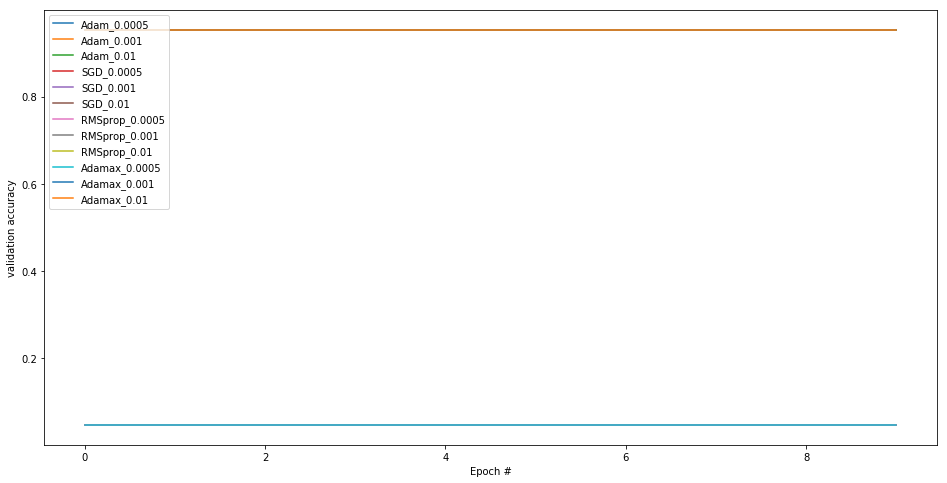

In [415]:
plots = []
for name in results_df['_name'].tolist(): 
    plots.append((modelhist[name]['history']['val_acc'], name))
obj.plot_multiple ('validation accuracy', plots)

#### 3.4.5) Plot Loss

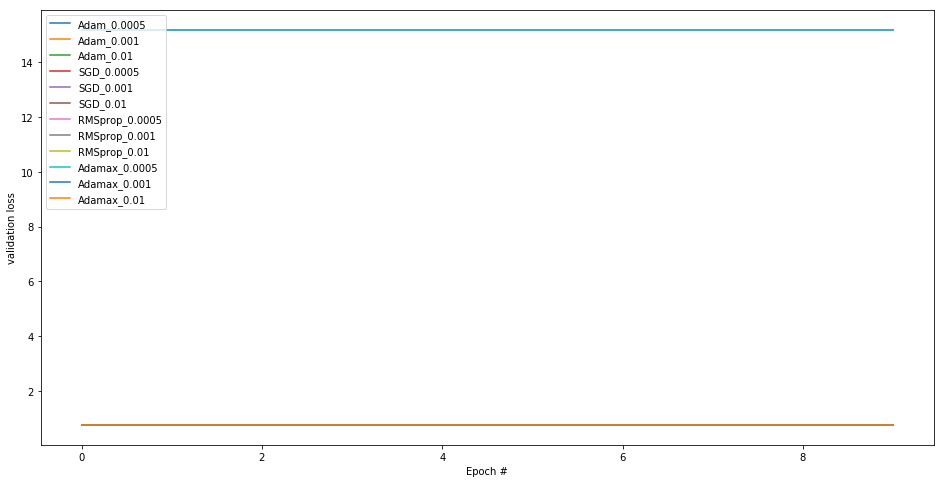

In [416]:
plots = []
for name in results_df['_name'].tolist(): 
    plots.append((modelhist[name]['history']['val_loss'], name))
obj.plot_multiple ('validation loss', plots)

#### 3.4.6) Save Best Model

In [417]:
modelhist['Adam_0.0005']['model']

In [418]:
obj.save_model(modelhist['Adam_0.0005']['model'], 'DNN_Adam_0.0005')

AttributeError: 'float' object has no attribute 'eval'

### 3.5) Optimized Model

#### 3.5.1) Train Cost Sensitive Learning eXplainable Neural Network

In [132]:
BATCH_SIZE = 64
EPOCHS = 5
LR = 0.0005 #0.00001 
model = Sequential([
	Dense(43, input_dim=43),
	Dense(1, activation='sigmoid')
])
model, history = obj.compile_and_fit(model, 'Adam', LR, x_train, y_train, BATCH_SIZE, EPOCHS, loss=custom_weigted_binary_crossentropy, verbose=1, metrics=['accuracy',sensitivity,specificity])

Train on 163712 samples, validate on 40928 samples
Epoch 1/5
163712/163712 [==============================] - 7s 41us/step - loss: 0.5352 - acc: 0.7632 - sensitivity: 0.1170 - specificity: 0.9121 - val_loss: 0.4313 - val_acc: 0.8277 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/5
163712/163712 [==============================] - 4s 25us/step - loss: 0.4622 - acc: 0.8120 - sensitivity: 0.0128 - specificity: 0.9959 - val_loss: 0.4286 - val_acc: 0.8277 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/5
163712/163712 [==============================] - 4s 25us/step - loss: 0.4559 - acc: 0.8126 - sensitivity: 0.0098 - specificity: 0.9973 - val_loss: 0.4280 - val_acc: 0.8277 - val_sensitivity: 6.0612e-04 - val_specificity: 0.9999
Epoch 4/5
163712/163712 [==============================] - 4s 25us/step - loss: 0.4534 - acc: 0.8127 - sensitivity: 0.0117 - specificity: 0.9971 - val_loss: 0.4272 - val_acc: 0.8278 - val_sensitivity: 0.0020 - val_specificity: 0.9998
E

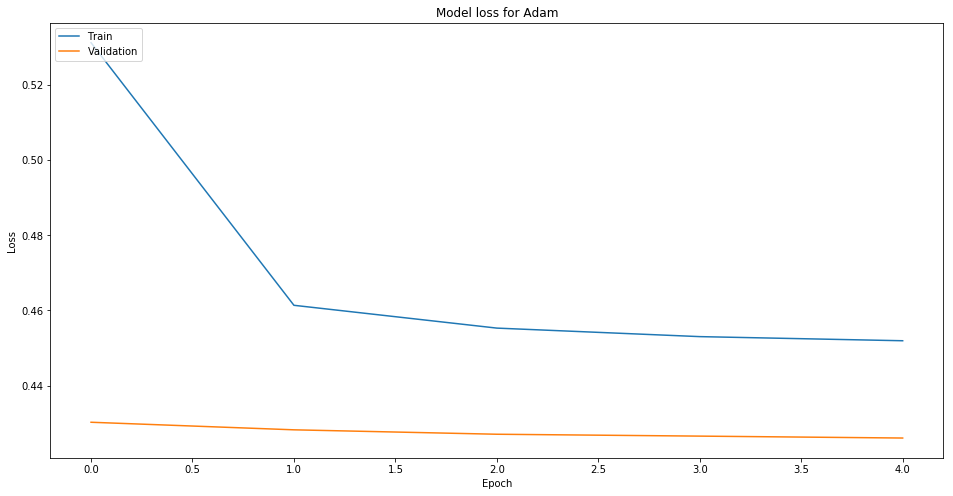

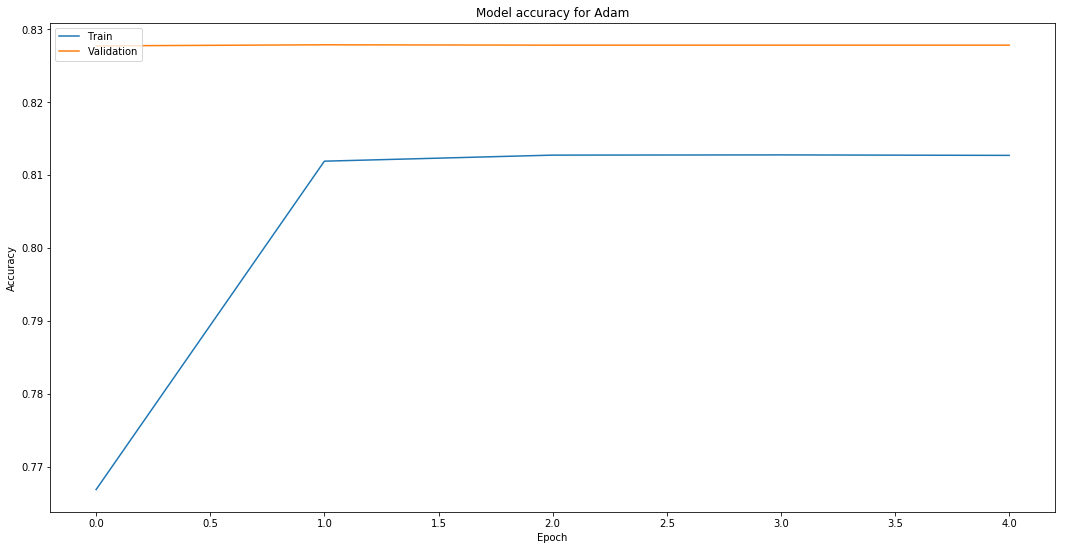

In [130]:
obj.plot_single (history.history, 'Adam')

#### 3.5.2) Get Predictions

In [133]:
y_pred = model.predict(x_test)
y_pred.shape

(51159, 1)

#### 3.5.3) Save Model

In [134]:
obj.save_model(model, 'XNN', True)


Saved trained model weights at: '/home/sri/SERG/2-csp-571_proj/models/XNN.h5'


In [136]:
prediction = pd.DataFrame(y_pred, columns=['XNN_prob']).to_csv('./pred/XNN_prob.csv')